# Weights & Biases 101 🥾🏕️

This notebook is intended to show you how to track your machine learning experiments using [Weights & Biases](https://wandb.ai).

Weights & Biases has two major components: a python client named `wandb` 🪄🐝  and a web application that allows you to store, query, visualize, and share metadata from your machine learning experiments, e.g. loss curves, evaluation metrics, model predictions... you can `.log` *just about* anything.

The client is open source and you can find the [source code on Github](http://github.com/wandb/wandb)! ⭐

The first step on our journey is to install the client, which is as easy as:

## 🪄 Install `wandb` library and login


The first step on our journey is to install the client, which is as easy as:



In [ ]:
!pip install c1_aem_sdk -qU

In [ ]:
!pip install "numpy<1.26.4"

In [ ]:
!pip install scikit-learn

## Log in to W&B
- You can explicitly login using `wandb login` or `wandb.login()` (See below)
- Alternatively you can set environment variables. There are several env variables which you can set to change the behavior of W&B logging. The most important are:
    - `WANDB_API_KEY` - find this in your "Settings" section under your profile
    - `WANDB_BASE_URL` - this is the url of the W&B server
- Find your API Token in "Profile" -> "Setttings" in the W&B App


In [ ]:
import c1_aem_sdk
import numpy as np
import random

In [ ]:
## Replace this with Cap1 Instance url
WANDB_HOST = "<cap1_instance_url>" #@param
# Equivalent to running "wandb login" in your shell

wandb.login(host= WANDB_HOST)

#
# Note that https://api.wandb.ai is the default and points to the publicly hosted
# app.
#
# Alternative you can configure this with environment variables:
# export WANDB_API_KEY="<your-api-key>"
# export WANDB_BASE_URL="<your-wandb-endpoint>"

Calling `wandb login` or `wandb.login` will write your API key to your `~/.netrc` file. __To authenticate the client in a headless job on the cloud, you will definitely want to use the `WANDB_API_KEY` environment variable__.

**Default Destination:** When a user signs up to the instance and joins a team, wandb will automatically write runs this team. This setting is controlled directly through your settings and can be updated by

*   Visiting https://<host-url>/settings
*   Look for `Default Team` section
*   Updating `Default location to create new projects` to entity of choice

In [28]:
import random
import math

WANDB_ENTITY = '<team-name>' #@param #Point to a team you are a member of!
WANDB_PROJECT = "workshop_wandb_intro" #@param
YOUR_NAME = "uma" #@param #We will use this for our filtering and grouping to make it easy for your to identify your runs in the project

In [ ]:
# Track hyperparameters and run metadata
WANDB_CONFIG = {
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
}

#Tags can be used to label runs with particular features that might not be obvious from the logged metrics
WANDB_TAGS = ["production", "baseline"]

"""
The pattern of "with wandb.init()..." causes wandb.finish() to be called as
soon as we leave the with block. This is especially useful when you have a script
or notebook that initializes multiple runs that you want to track separately.
"""

# Launch 5 simulated experiments
total_runs = 5
for exp in range(total_runs):
  #Start a new run to track this script
  run = wandb.init(
      entity=WANDB_ENTITY,       # Set the Entity to destination team
      project=WANDB_PROJECT,     # Set the project where this run will be logged
      name=f"experiment_{exp}",  # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      group=f"production_group_{YOUR_NAME}", # For organizing runs (e.g. distributed training)
      job_type='training',		   # For organizing runs (e.g. preprocessing vs. training)
      config=WANDB_CONFIG,       # For saving experiment parameters
      tags= WANDB_TAGS           # For organizing runs together or applying temporary labels
      )

  # This simple block simulates a training loop logging metrics
  epochs = 10
  offset = random.random() / 5
  for epoch in range(2, epochs):
      acc = 1 - 2 ** -epoch - random.random() / epoch - offset
      loss = 2 ** -epoch + random.random() / epoch + offset
      # Scalar metrics can be logged by passing them in to  run.log as a dictionary with a name.
      run.log({"acc": acc, "loss": loss})

  # Mark the run as finished
  run.finish()

run_id_for_api = run.id #will be utilized when covering api usage

### Organizing logged metrics?

We treat / as a separator for organizing logged panels in the W&B UI. By default, the component of the logged item's name before a / is used to define a group of panel called a "Panel Section".

```
run.log({"val/loss": 1.1, "val/acc": 0.3})
run.log({"train/loss": 0.1, "train/acc": 0.94})
```


### Wandb Step & Custom Metrics

1. **What is the `wandb Step`?**
    
    The wandb step tracks the progression of your training or experimentation process. Steps are monotonically increasing and increment everytime you call `run.log({key:val})`. To keep your metrics step synchornized, we recommend you bundle your metrics into the same `log()` call.

If interested in using a custom x axis that is not wandb step use `define_metric` to set a custom x axis.Custom x-axes are useful in contexts where you need to log to different time steps in the past during training, asynchronously. Example below


In [ ]:
#Organizing logged metrics
run = wandb.init(
    entity = WANDB_ENTITY,
    project=WANDB_PROJECT,
    group = YOUR_NAME,
    name = "organized_metrics_run"
)

# Define a custom x axis metric
wandb.define_metric("custom/custom_step")

# Define which metrics to plot against that x-axis
wandb.define_metric("custom/unique_metric", step_metric='custom/custom_step')

epochs = 100
offset = random.random() / 5
for epoch in range(2, epochs):
    val_acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    val_loss = 2 ** -epoch + random.random() / epoch + offset
    train_acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    train_loss = 2 ** -epoch + random.random() / epoch + offset
    run.log({"train/acc": train_acc,
              "train/loss": train_loss,
              "val/acc": val_acc,
              "val/loss": val_loss,
             "custom/custom_step": epoch**2,
             "custom/unique_metric": 1/(epoch+1)
             })

run.finish()

## Run Resuming

Resuming runs is a powerful feature that allows you to actively continue your trainings from where you left off. To resume runs, set the args `id` and `resume` when initializing the run, `wandb.init(id=<run-id>, resume=<val>)`. For more information on run resuming see our [resuming docs](https://docs.wandb.ai/guides/runs/resuming)

| Argument | Description                                        | Run ID exists                                    | Run ID does not exist                                  | Use case                                           |
|----------|----------------------------------------------------|--------------------------------------------------|-------------------------------------------------------|----------------------------------------------------|
| `must`   | W&B must resume run specified by the run ID.       | W&B resumes run with the same run ID.            | W&B raises an error.                                  | Resume a run that must use the same run ID.        |
| `allow`  | Allow W&B to resume run if run ID exists.          | W&B resumes run with the same run ID.            | W&B initializes a new run with specified run ID.      | Resume a run without overriding an existing run.   |
| `never`  | Never allow W&B to resume a run specified by run ID. | W&B raises an error.                              | W&B initializes a new run with specified run ID.      | Prevent resumption and always start a new run.     |


**Example Use Cases**

**Long-Running Training Jobs:** When training a model on a large dataset that requires several days to complete, you might need to pause the job due to resource limits. Using run resume, you can restart the training process without losing progress.

**Cluster Time Limits:** In environments where compute jobs are limited by wall-time (e.g., SLURM or other job schedulers), you can use the resume feature to pick up right where the job was terminated, making it easier to manage long-running experiments.

**Experiment Interruptions:** In case of unexpected interruptions (e.g., hardware failure, power outage), the resume feature ensures that you can continue the experiment once the issue is resolved, preventing data loss and ensuring consistency.

In [ ]:
run = wandb.init(
    entity = WANDB_ENTITY,
    project=WANDB_PROJECT,
    group = f"{YOUR_NAME}",
    name= f"exp_run_with_resume_{YOUR_NAME}"
)

#Log 5 points of the metric
for i in range(5):
  run.log({"metric1": i})


run.finish()

#First inspect run result before executing the cell below!

In [ ]:
resumed_run = wandb.init(
    entity = WANDB_ENTITY,
    project = WANDB_PROJECT,
    group = f"{YOUR_NAME}",
    name=  f"exp_run_with_resume_{YOUR_NAME}",
    id = run.id, #If you do not pass in an id, wandb will use last known run id.
    resume = "must"
)

#log an additional 5 points to metric1 and log a new metric, metric2. Notice how metric2 begins at step 5!
for i in range(5):
  resumed_run.log({"metric1": i,
             "metric2": i**2})
resumed_run.finish()


## Rich Media - Brief

W&B supports images, video, audio, and more. Log rich media to explore your results and visually compare your runs, models, and datasets. Read on for examples and how-to guides.

For a first list of loggable types check out [these docs](https://docs.wandb.ai/ref/python/data-types).

### Logging a single image

In [ ]:
import wandb
from PIL import Image
import numpy as np

# Initialize a new W&B run
run = wandb.init(project=WANDB_PROJECT, name="image_logging_example")

# Load or create an image (example using a random numpy array)
image = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)  # Random 100x100 RGB image
image_pil = Image.fromarray(image)

# Log the image to W&B
run.log({"sample_image": wandb.Image(image_pil)})

# Finish the run
run.finish()

To log an overlay, you'll need to provide a dictionary with the following keys and values to the `masks` keyword argument of `wandb.Image`:

- one of two keys representing the image mask:
  - "mask_data": a 2D NumPy array containing an integer class label for each pixel
  - "path": (string) a path to a saved image mask file
- "class_labels": (optional) a dictionary mapping the integer class labels in the image mask to their readable class names

To log multiple masks, log a mask dictionary with multiple keys, as done below

### Log Dataframes of Media

You can also log `pandas.DataFrame` objects with `.log`! These will be converted into a `wandb.Table` (docs) and interactievly displayed inside of W&B.

Note: One of the most powerful features of `wandb.Table`s is that you can include any `wandb` type as a cell value! This includes, images, plots, videos, audio... almost anything 🤩

Below we will use a the Oxford-IIIT Pet Dataset of 37 different pet breeds along with corresponding segmentation masks provided in the annotations for logging media example

In [ ]:
!curl -SL -qq https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz > images.tar.gz
!curl -SL -qq https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz > annotations.tar.gz
!tar -xzf images.tar.gz
!tar -xzf annotations.tar.gz

In [ ]:
import os
import wandb
import numpy as np
from PIL import Image
from pathlib import Path

In [ ]:
#Utility functions

# Function to load an image and mask
def load_image_and_mask(image_path, mask_path):
    image = np.array(Image.open(image_path))
    mask = np.array(Image.open(mask_path))
    return image, mask

# Function to create W&B mask overlay
def wb_mask(image, mask):
    return wandb.Image(image, masks={"predictions": {"mask_data": mask}}, caption="Segmentation Image")

def log_single_images(path_img, path_lbl):
  # Single Image and Mask Logging
  image_path = path_img / 'Abyssinian_1.jpg'
  mask_path = path_lbl / 'Abyssinian_1.png'
  image_np, mask_np = load_image_and_mask(image_path, mask_path)
  return image_np, mask_np

def wandb_table_multiple_imags(path_img,path_lbl, num_images):
    table = wandb.Table(columns=["ID", "Original Image", "Image with Mask"])
    # Multiple Images Logging in a Table
    table = wandb.Table(columns=["ID", "Original Image", "Image with Mask"])

    # Log first X images and their masks to the table
    for each in os.listdir(path_img)[:num_images]:  # limiting to first X images
        image_path = path_img / each
        mask_path = path_lbl / f'{Path(each).stem}.png'  # Adjust to match mask filenames
        image_np, mask_np = load_image_and_mask(image_path, mask_path)

        # Create mask overlay using W&B
        mask_img = wb_mask(image_np, mask_np)

        # Add image path, original image, and image with mask to the table
        table.add_data(str(image_path), wandb.Image(image_np), mask_img)

    return table

Logging a single image and a table of images with segmentation masks

In [ ]:
run = wandb.init(
    entity = WANDB_ENTITY,
    project=WANDB_PROJECT,
    group=YOUR_NAME,
    name="logging_rich_media",
    )

# Define paths
path_img = Path('images')
path_lbl = Path('annotations/trimaps')

image_np, mask_np = log_single_images(path_img, path_lbl)

# Log single image and segmentation mask
run.log({
    "input_image": wandb.Image(image_np, caption="Input Image"),
    "segmentation_mask": wb_mask(image_np, mask_np)
})

#Log tables of images and segmentation mask
image_tables = wandb_table_multiple_imags(path_img, path_lbl, 30)

# Log the table
run.log({"Segmentation Table": image_tables})

run.finish()

### Log Sequences of Media

If you periodically call `run.log` to log a number (for example, loss), Weights & Biases will automatically render a line plot showing the change in that value over time (a loss curve). You can also log media under a key more than once over the course of an experiment, in which case Weights & Biases will display that media with a step slider so you can scrub over the course of the experiment and see how it changed. This is particularly useful for seeing how model predictions and visualizations of model performance (e.g. a precision/recall curve) change over time. In the example below, we log a `wandb.Image` repeatedly just to demonstrate how this works. Below is an example of doing the same with audio.

In [ ]:
%%sh
curl https://parade.com/.image/t_share/MTkwNTgwOTUyNjU2Mzg5MjQ1/albert-einstein-quotes-jpg.jpg > image.jpg

In [ ]:
from PIL import Image, ImageFilter
import pandas as pd
# Load image with pillow, resize to 512 square
im = Image.open("./image.jpg").resize((512, 512))
images = []
with wandb.init(project = WANDB_PROJECT) as run:

  for step in range(10):

    # Log image
    images.append( (step, wandb.Image(im)))
    run.log({"image": wandb.Image(im)})

    # Apply small Gaussian blur
    im = im.filter(ImageFilter.GaussianBlur(radius=1.5))

  # Also log the images + associated logging step to a W&B Table
  run.log({ "images_df": pd.DataFrame( images, columns = ["step", "images"])})

## Anatomy of a `Run` 🩺

The `Run` stores a detailed record of an experiment within a few specific data structures. The important things to know about are
- `run.config` is a dictionary like structure that stores configuration data for a run, like the path to input data or training hyperparameters. You can instatiate the config by passing a dictionary to `wandb.init(config=<config-dict>)`.
- `run.history` is a list of dictionaries that stores the sampled historical values of metrics and media over the course of an experiment. We can append a new snapshot of our training metrics by calling `run.log(<metric-dict>)` - full metrics access would be given via `run.scan_history`
- `run.summary` is a dictionary for recording summary metrics or media. By default the `summary` will contain the most recent values logged for each metric, you can overwrite and add elements as you like.

Use the [Public API](https://docs.wandb.ai/guides/track/public-api-guide#export-data) to interact with the data that you have saved to W&B.

To use the Public API, you'll often need the run path which is `<entity>/<project>/<run_id>`, found in the run overview page, or the path to your projects


A few basic examples below

In [ ]:
import numpy as np

api = wandb.Api()

run_id_for_api = "" # fill in the run path you would like to access. This can be found in the run overview page.

#Output timestamp and loss saved with run.log({"accuracy": loss})
run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{run_id_for_api}")
for i, row in run.history().iterrows():
    print(row["_timestamp"], row["loss"])

#Update metrics for a run, after the run has finished
run.summary["acc"] = 0.9
run.summary["accuracy_histogram"] = wandb.Histogram(np.random.rand(5))
run.summary.update()

#Rename a metric in a run, after the run has finished
run.summary["new_acc"] = run.summary["acc"]
del run.summary["acc"]
run.summary.update()

#### Querying all points in a run:


In [ ]:
api = wandb.Api()


# access the run object via the api
run = api.run('<entity>/<project>/<run_id>') # pass in a run path once again!


# full_history is an iterator that yields dictionaries from the run's history, one at a time.
full_history = run.scan_history()


# list of dictionaries where each dictionary represents a single step's data from the run's history.
losses = [row for row in full_history]

# Hyperparameter tuning with sweeps

Fundamentally, a Sweep combines a strategy for trying out a bunch of hyperparameter values with the code that evalutes them. Whether that strategy is as simple as trying every option or as complex as BOHB, Weights & Biases Sweeps have you covered. You just need to define your strategy in the form of a configuration.

###  Step 1️. Define the Sweep


In [ ]:
sweep_config = {
    'method': 'bayes',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize',
        'name': 'train/loss'
        },
    'parameters': {
        'batch_size': {'values': [16, 32, 64]},
        'learning_rate': {'max': 0.1, 'min': 0.0001},
        'epochs': {'min': 5, 'max':15}

     }
}

In [ ]:
from pprint import pprint
pprint(sweep_config)

### Step 2. Initialize the Sweep

The clockwork taskmaster in charge of our Sweep is known as the Sweep Controller. As each run completes, it will issue a new set of instructions describing a new run to execute. These instructions are picked up by agents who actually perform the runs.

In a typical Sweep, the Controller lives on the W&B server, while the agents who complete runs live on your machine(s), like in the diagram below. This division of labor makes it super easy to scale up Sweeps by just adding more machines to run agents!

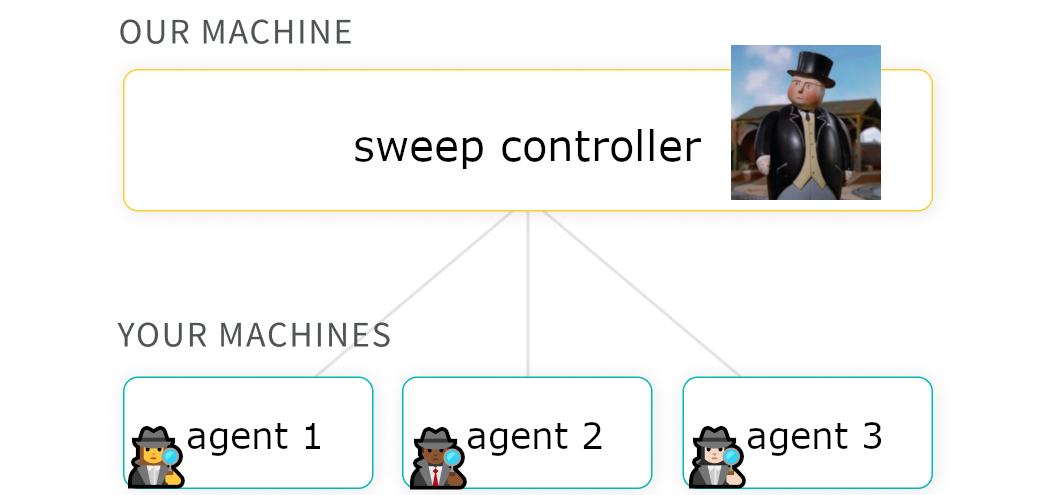

In [ ]:
sweep_id = wandb.sweep(sweep_config, project=WANDB_PROJECT)

### Step 3. Define Training Procedure and run Sweep Agent

In [ ]:
import torch
import wandb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST

# Define a simple transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor()  # Directly convert PIL image to Tensor
])

# Load the dataset with the corrected transformation
train_dataset = FashionMNIST("./data/", download=True, train=True, transform=transform)


# logging dataset as an artifact
run = wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY)

artifact = wandb.Artifact("fashion_mnist_dataset", type="dataset")
artifact.add_dir("./data/")
run.log_artifact(artifact)
run.finish()


In [ ]:
# Define the CNN model
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(64 * 6 * 6, 600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

def train_fmnist(config=None):
    run = wandb.init(config=config, job_type='hyperparameter-tuning')

    artifact = run.use_artifact(f'{WANDB_ENTITY}/{WANDB_PROJECT}/fashion_mnist_dataset:v0', type='dataset')
    config = run.config

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = FashionCNN().to(device)

    # Initialize DataLoader
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, pin_memory=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    wandb.watch(model, log="all", log_graph=True)

    for epoch in range(config.epochs):
        losses = []
        for idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            if (idx + 1) % 25 == 0:
                avg_loss = sum(losses) / len(losses)
                run.log({"train/loss": avg_loss, "train/losses": wandb.Histogram(losses)})
                losses = []

            if idx == 0:
                table = wandb.Table(columns=["image", "label", "prediction"])
                for im, lab, pred in zip(images, labels, outputs):
                    pred_label = torch.argmax(pred).item()
                    table.add_data(wandb.Image(im.cpu()), lab.item(), pred_label)
                run.log({"train/predictions": table})

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    torch.save(model.state_dict(), "model.pth")
    model_artifact = wandb.Artifact("FashionMNIST-model", type="model")
    model_artifact.add_file("model.pth")
    run.log_artifact(model_artifact)

    run.finish()

In [ ]:
wandb.agent(sweep_id, train_fmnist, count=10)

## K-fold cross validation with sweeps + grouping

In [ ]:
import wandb
import numpy as np
import sklearn
from sklearn.model_selection import KFold
import random

# Sweep configuration
sweep_config = {
    'method': 'grid',  # other options: 'random', 'bayes'
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.01, 0.1]
        },
        'epochs': {
            'values': [5, 10]
        }
    }
}

In [ ]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="kfold_crossval_sweep")

In [ ]:
# Mock dataset
def generate_mock_data():
    # Create some mock data for cross-validation
    X = np.random.rand(100, 10)
    y = np.random.randint(0, 2, 100)
    return X, y

# Train function with k-fold cross-validation
def train(config=None):
    # Initialize a new W&B run
    with wandb.init(config=config, group="cross_validation_group") as run:
        config = wandb.config

        # Generate mock data
        X, y = generate_mock_data()

        # Perform k-fold cross-validation
        k = 5
        kf = KFold(n_splits=k)
        fold_metrics = []

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            # Split the data into training and testing sets
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]


            # Simulate a simple training process #
            val_accuracy = random.uniform(0.5, 1.0)  # Random accuracy as a placeholder

            # Log each fold's accuracy to W&B
            wandb.log({"fold": fold, "val_accuracy": val_accuracy})
            fold_metrics.append(val_accuracy)

        # Log the average validation accuracy across all folds
        avg_val_accuracy = np.mean(fold_metrics)
        wandb.log({"avg_val_accuracy": avg_val_accuracy})

In [ ]:
wandb.agent(sweep_id, function=train)

# Artifacts

Use W&B Artifacts to track and version data as the inputs and outputs of your W&B Runs. In addition to logging hyperparameters, metadata, and metrics to a run, you can use an artifact to log the dataset used to train the model as input and the resulting model checkpoints as outputs.




For this demo, we are going to go through the workflow of
1. Creating a dataset
2. Logging it to wandb
3. Processing that dataset
4. Logging the processed data to wandb
5. Conducting model training
6. Viewing the entire lineage of this process in the wandb UI

## Create a Dataset
Let's create some datasets that we can work with in this example.

In [ ]:
import os
import numpy as np
import csv

directory = "dataset"
os.makedirs(directory, exist_ok=True)
file1, file2 = os.path.join(directory, "file1.csv"), os.path.join(directory, "file2.csv")

def generate_dummy_data(num_samples):
    data = [
        np.random.normal(50, 10, num_samples),
        np.random.randint(1, 100, num_samples),
        np.random.choice(['A', 'B', 'C', 'D'], num_samples),
        np.random.uniform(0.0, 1.0, num_samples)
    ]
    return zip(*data)

def save_to_csv(file, data):
    with open(file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['feature1', 'feature2', 'feature3', 'feature4'])
        writer.writerows(data)

num_samples = 100
save_to_csv(file1, generate_dummy_data(num_samples))
save_to_csv(file2, generate_dummy_data(num_samples))

The general workflow for creating an Artifact is:

1. Intialize a run.
2. Create an Artifact.
3. Add a any files, directories, or pointers to the new Artifact that you want to track and version.
4. Log the artifact in the W&B platform.

See the [Artifacts Reference guide](https://www.google.com/url?q=https%3A%2F%2Fdocs.wandb.ai%2Fref%2Fpython%2Fartifact) for more information and other commonly used arguments, including how to store additional metadata.

Each time the above `log_artifact` is executed, wandb will create a new version of the Artifact within Weights & Biases if the underlying data has changed.

## Logging this dataset artifact

In [ ]:
run = wandb.init(entity=WANDB_ENTITY, project=WANDB_PROJECT, job_type='log_dataset')

artifact = wandb.Artifact(f"my_first_artifact_{YOUR_NAME}", type="dataset")
# the below will add two individual files to the artifact.
artifact.add_file(local_path=f"{directory}/file1.csv")
artifact.add_file(local_path=f"{directory}/file2.csv")

# or the below if you wanted to add the entire directory contents.
artifact.add_dir(local_path=f"{directory}")
# explictly log the artifact to Weights & Biases.
run.log_artifact(artifact)

run.finish()

## Processing and Consuming the dataset Artifact

When you want to use a specific version of an Artifact in a downstream task, you can specify the specific version you would like to use via either `v0`, `v1`, `v2` and so on, or via specific aliases you may have added. The latest alias always refers to the most recent version of the Artifact logged.

The proceeding code snippet specifies that the W&B Run will use an artifact called my_first_artifact with the alias latest. We will take a step to preprocess our dataset and relog it to wandb, so we can see the lineage up until this point:

In [ ]:
run = wandb.init(entity=WANDB_ENTITY, project=WANDB_PROJECT, job_type='process_dataset')
artifact = run.use_artifact(artifact_or_name=f"my_first_artifact_{YOUR_NAME}:latest") # this creates a reference within Weights & Biases that this artifact was used by this run.
path = artifact.download() # this downloads the artifact from Weights & Biases to your local system where the code is executing.

print(f"Data directory located at {path}")

In [ ]:
processed_directory = "processed_dataset"
os.makedirs(processed_directory, exist_ok=True)
file1, file2 = os.path.join(directory, "file1_processed.csv"), os.path.join(directory, "file2_processed.csv")

In [ ]:
# Step 2: Function to process and save the modified CSV data
def process(input_file_path, output_file_path):
    modified_data = []
    with open(input_file_path, 'r') as f:
        reader = csv.reader(f)
        headers = next(reader)  # Skip headers
        for row in reader:
            # Example modification: Adjust feature1 by adding a constant
            row[0] = str(float(row[0]) + 10)  # Modify feature1
            modified_data.append(row)

    # Save the modified data to the output path
    with open(output_file_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)  # Write the headers back
        writer.writerows(modified_data)

# Apply modification to the CSV files
process(os.path.join(path, "file1.csv"), os.path.join(processed_directory, "file1_processed.csv"))
process(os.path.join(path, "file2.csv"), os.path.join(processed_directory, "file2_processed.csv"))

In [ ]:
# Step 4: Create a new artifact to store the modified data
processed_artifact = wandb.Artifact(
    f"my_processed_artifact_{YOUR_NAME}",
    type="processed_dataset"
)

# Add the modified CSV files to the new artifact
processed_artifact.add_file(local_path=f"{processed_directory}/file1_processed.csv")
processed_artifact.add_file(local_path=f"{processed_directory}/file1_processed.csv")

# or the below if you wanted to add the entire directory contents.
processed_artifact.add_dir(local_path=f"{processed_directory}")

# Step 5: Log the processed artifact
run.log_artifact(processed_artifact)

# Finish the run
run.finish()

## Using our dataset during model training

In [ ]:
import torch
import torch.nn as nn

run = wandb.init(
    entity = WANDB_ENTITY,
    project=WANDB_PROJECT,
    group=YOUR_NAME,
    job_type = "training",
    config={'param': 42}
)

# Use our processed dataset in our training run
# this creates a reference within Weights & Biases that this artifact was used by this run
artifact = run.use_artifact(artifact_or_name=f"my_processed_artifact_{YOUR_NAME}:latest")

#Save simple neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = SimpleModel()

# doing some dummy logging here
for i in range(5):
  run.log({"acc": random.random()})

# Save the model and log to artifacts
model_path = "simple_model.pth"
torch.save(model.state_dict(), model_path)

# Log the model as an artifact
art = wandb.Artifact(name=f"simple-model-{YOUR_NAME}", type=f"model")
art.add_file(model_path)
run.log_artifact(art)

run.finish()

For more information on ways to customize your Artifact download, including via the command line, see the [Download and Usage guide](https://docs.wandb.ai/guides/artifacts/download-and-use-an-artifact).

## How can we see which experiments used a particular dataset?


If we want to see which wandb runs consumed a specific dataset, we can do this two ways:
1. Viewing the lineage in the UI
2. Programmatically accessing which run names and ids consumed a specific dataset (below)

In [ ]:
run = wandb.init(
    entity = WANDB_ENTITY,
    project=WANDB_PROJECT,
)

artifact = run.use_artifact(artifact_or_name=f"my_processed_artifact_{YOUR_NAME}:latest")

for run in artifact.used_by():
  print(run.name)
  print(run.summary)

## Update Artifact version metadata
You can update the description, metadata, and alias of an artifact on the W&B platform during or outside a W&B Run.

This example changes the description of the my_first_artifact artifact inside a run:

In [ ]:
run = wandb.init(entity=WANDB_ENTITY, project=WANDB_PROJECT)
artifact = run.use_artifact(artifact_or_name=f"my_first_artifact_{YOUR_NAME}:latest")
artifact.description = "This is an edited description."
artifact.metadata = {"source": "local disk", "internal data owner": "platform team"}
artifact.save()  # persists changes to an Artifact's properties
run.finish()

## Code Snippet for Logging Reference Artifacts

Artifacts currently support the following URI schemes:

* **http(s)://:** A path to a file accessible over HTTP. The artifact will track checksums in the form of etags and size metadata if the HTTP server supports the ETag and Content-Length response headers.
* **s3://:** A path to an object or object prefix in S3. The artifact will track checksums and versioning information (if the bucket has object versioning enabled) for the referenced objects. Object prefixes are expanded to include the objects under the prefix, default up to 100,000 objects.
* **gs://:** A path to an object or object prefix in GCS. The artifact will track checksums and versioning information (if the bucket has object versioning enabled) for the referenced objects. Object prefixes are expanded to include the objects under the prefix, default up to 100,000 objects.
See below for an example of reference local files

In [ ]:
run = wandb.init(entity=WANDB_ENTITY,
                project=WANDB_PROJECT,
                job_type="upload-references")
artifact = wandb.Artifact(name=f"local-file-references_{YOUR_NAME}", type="reference-dataset")
artifact.add_reference("file:///content/sample_data", checksum=True)
run.log_artifact(artifact)
run.finish()

## **Artifacts Time-to-live (TTL)**

W&B Artifacts supports setting time-to-live policies on each version of an Artifact. The following examples show the use TTL policy in a common Artifact logging workflow. We'll cover:

* Setting a TTL policy when creating an Artifact
* Retroactively setting TTL for a specific Artifact aliases

## Setting TTL on New Artifacts
Below we create two new Artifacts from the colab provided sample_data
- mnist_test.csv
- mnist_train_small.csv

Upload them as artifacts files to artifact of type `mnist_dataset` and assign them a TTL

In [ ]:
from datetime import timedelta

run = wandb.init(entity=WANDB_ENTITY,
                project=WANDB_PROJECT,
                job_type="raw-data")

raw_mnist_train = wandb.Artifact(
    f"mnist_train_small_{YOUR_NAME}",
    type="mnist_dataset",
    description="Small MNIST Training Set"
)

raw_mnist_train.add_file("sample_data/mnist_train_small.csv")
raw_mnist_train.ttl = timedelta(days=10)
run.log_artifact(raw_mnist_train, aliases=["small", "mnist", "train"])

raw_mnist_test = wandb.Artifact(
    f"mnist_test_small_{YOUR_NAME}",
    type="mnist_dataset",
    description="Small MNIST Test Set"
)

raw_mnist_test.add_file("sample_data/mnist_test.csv")
raw_mnist_test.ttl = timedelta(days=10)
run.log_artifact(raw_mnist_test, aliases=["small", "mnist", "test"])

run.finish()

# Full pipeline - data upload, model training, linking the best model to registry

The below pipeline includes:

* Data Versioning: The Heart Disease dataset is split into training, validation, and test sets, each logged as a W&B artifact for easy tracking and reproducibility. The training dataset we linked to our dataset registry

* Model Training: A neural network is trained on the training set, with performance monitored on the validation set. The best model version is saved and versioned as a W&B artifact which is then linked to our model registry

* What It Showcases:
How to use W&B for seamless data and model versioning.
Best practices for tracking model performance during training and evaluation.
Efficient and reproducible ML workflows in a production-ready environment.

In [16]:
COLLECTION_NAME = "heart-disease" #@param {type: "string"}

In [23]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from io import StringIO

# Load the Heart Disease dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

In [24]:
# Data download and processing
raw_data = !CURL https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
clean_rows = [
    row
    for row in raw_data
    if row.strip()                  # drop the empty string
       and "--:--:--" not in row    # progress-bar lines
       and "%" not in row           # header / percent lines
       and "Dload" not in row       # second header line
]

csv = '\n'.join(clean_rows)
data = pd.read_csv(StringIO(csv), header=None, names=columns)

# Replace missing values ('?') with NaN and drop rows with NaN values
data.replace('?', np.nan, inplace=True)
data = data.dropna().astype(float)

# Convert target variable: 0 = no heart disease, 1 = presence of heart disease
data['target'] = (data['target'] > 0).astype(int)

# Shuffle the dataset to ensure random distribution
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Perform a train/validation/test split (60/20/20)
train_size = int(0.6 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size

train_data = data[:train_size]
val_data = data[train_size:train_size + val_size]
test_data = data[train_size + val_size:]

# Save the entire dataset as a CSV file
data.to_csv("heart_disease_full_dataset.csv", index=False)

The following function is used to save a dataset to a file and log it as an artifact

In [26]:
# Simple function to save log dataset artifacts
def save_and_log_dataset(data, filename, artifact_name, aliases):
    # Save the dataset as a CSV file
    data.to_csv(filename, index=False)

    # Create and log the dataset artifact
    dataset_artifact = wandb.Artifact(name=artifact_name, type='dataset')
    dataset_artifact.add_file(filename)
    wandb.log_artifact(dataset_artifact, aliases=aliases)

    return dataset_artifact

The following cell is going to save our train, validation, and test datasets as artifacts, as well as link our training dataset to our Training Datasets registry

In [ ]:
#Upload data to wandb

run = wandb.init(entity=WANDB_ENTITY,
                project=WANDB_PROJECT,
                group = YOUR_NAME,
                job_type="heart-disease-data-uploads",
                name = f"heart_disease_data_uploads_{YOUR_NAME}",
                tags = ["data-upload"]
                )

# Save and log the entire dataset
full_artifact = save_and_log_dataset(data, "heart_disease_full_dataset.csv", f'heart_disease_full_dataset_{YOUR_NAME}', ["initial_commit", "complete_dataset"])

# Save and log the training dataset
train_artifact = save_and_log_dataset(train_data, "heart_disease_train_dataset.csv", f'heart_disease_train_dataset_{YOUR_NAME}', ["initial_commit", "train_split"])

# Save and log the validation dataset
val_artifact = save_and_log_dataset(val_data, "heart_disease_val_dataset.csv", f'heart_disease_validation_dataset_{YOUR_NAME}', ["initial_commit", "validation_split"])

# Save and log the test dataset
test_artifact = save_and_log_dataset(test_data, "heart_disease_test_dataset.csv", f'heart_disease_test_dataset_{YOUR_NAME}', ["initial_commit", "test_split"])


#Log all dataset to W&B tables for visual analysis
run.log({f"train_data_table_{YOUR_NAME}": wandb.Table(dataframe=train_data),
           f"test_data_table_{YOUR_NAME}": wandb.Table(dataframe=test_data),
           f"validation_data_table_{YOUR_NAME}": wandb.Table(dataframe=val_data)})

# Linking Training Dataset to collection in dataset registry
target_path = f"wandb-registry-dataset/{COLLECTION_NAME}"

# this line will only work if you are logging to a team entity - which has access to Registry
run.link_artifact(
  artifact=train_artifact,
  target_path= target_path
)

run.finish()

The following cell is going to pull the latest training dataset from our training dataset registry so we can start training on it.

During training, we save our model checkpoints as artifacts, but we're going to promote our best model from our training to our model registry

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#simple function for loading artifacts from wandb
def load_and_split_data(entity, project, artifact_name, your_name, split_name):

    artifact_full_name = f'{entity}/{project}/{artifact_name}_{your_name}:latest'
    artifact = wandb.use_artifact(artifact_full_name, type='dataset')
    artifact_dir = artifact.download()#If you are using local version of artifact, you can simple utilize wandb.use_artifact() only instead of downloading to associated lineage to the artifact

    data = pd.read_csv(f"{artifact_dir}/heart_disease_{split_name}_dataset.csv")

    X = torch.tensor(data.drop("target", axis=1).values, dtype=torch.float32)
    y = torch.tensor(data["target"].values, dtype=torch.float32)

    return X, y


# Initialize training run
run = wandb.init(entity=WANDB_ENTITY,
                project=WANDB_PROJECT,
                group = YOUR_NAME,
                job_type="heart-disease-training",
                name = f"heart_disease_training_validation_{YOUR_NAME}"
                )


# Explicitly accessing Training data
artifact = run.use_artifact('wandb-registry-Training Datasets/heart-disease:latest', type='dataset')
artifact_dir = artifact.download()

data = pd.read_csv(f"{artifact_dir}/heart_disease_train_dataset.csv")

X_train = torch.tensor(data.drop("target", axis=1).values, dtype=torch.float32)
y_train = torch.tensor(data["target"].values, dtype=torch.float32)

# Load validation data
X_val, y_val = load_and_split_data(WANDB_ENTITY, WANDB_PROJECT, 'heart_disease_validation_dataset', YOUR_NAME, 'val')

# Define a simple neural network model
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size):
        super(HeartDiseaseModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

model = HeartDiseaseModel(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_performance = float('inf')
version = 1

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate and log training accuracy
    predictions = (outputs >= 0.5).float()
    train_accuracy = (predictions == y_train).float().mean().item()

    run.log({"train/epoch": epoch, "train/train_loss": loss.item(), "train/train_accuracy": train_accuracy})

    # Evaluate the model on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val).squeeze()
        val_loss = criterion(val_outputs, y_val).item()

        # Calculate and log validation accuracy
        val_predictions = (val_outputs >= 0.5).float()
        val_accuracy = (val_predictions == y_val).float().mean().item()

        run.log({"val/val_loss": val_loss, "val/val_accuracy": val_accuracy})

        if val_loss < best_performance:
            best_performance = val_loss
            model_path = f"heart_disease_model_v{version}.pth"
            torch.save(model.state_dict(), model_path)
            artifact = wandb.Artifact(name=f'heart_disease_model_{YOUR_NAME}', type='model')
            artifact.add_file(model_path)
            wandb.log_artifact(artifact, aliases=[f"v{version}", "best"])
            version += 1

# linking the best model to collection in model registry
target_path = f"wandb-registry-Model/{COLLECTION_NAME}"

# Giving it the production alias since this is our best model32
# this line will only work if you are logging to a team entity
run.link_artifact(
  artifact=artifact,
  target_path= target_path,
  aliases=["production"]
)

run.finish()

# Expanded Capabilities

Here are some more expanded capabilities of the SDK that we didn't get a chance to touch on today, but am including for reference:
1. Custom Charts
2. Offline Runs
3. Alerts
4. Logging Rich Media
5. Settings & Environment Variables


### Custom Charts

You can create Custom Charts to create charts that are more complex and not offered by the default UI. Log arbitrary tables of data and visualize them exactly how you want. Control details of fonts, colors, and tooltips with the power of Vega. Below is an example of logging a PR curve using a built-in Vega spec.

Try even more examples in this [colab](https://tiny.cc/custom-charts)

In [ ]:
run = wandb.init(project='my-awesome-project')

# Generate dummy ground truth and prediction values
# Assume we have 3 classes for a multi-class classification problem

# Number of samples
num_samples = 100

# Number of classes
num_classes = 3

# Ground truth labels (random integers between 0 and num_classes-1)
ground_truth = np.random.randint(0, num_classes, size=num_samples)

# Prediction probabilities (random float values between 0 and 1, for each class)
predictions = np.random.rand(num_samples, num_classes)

# Normalize the predictions so that they sum to 1 for each sample (softmax-like behavior)
predictions = predictions / predictions.sum(axis=1, keepdims=True)

# Optional labels for the classes
labels = ['Class 0', 'Class 1', 'Class 2']

# Classes to plot (if you want to limit to specific classes)
classes_to_plot = [0, 1, 2]

# Generate the PR curve using wandb
pr_curve_plot = wandb.plot.pr_curve(ground_truth, predictions, labels=labels, classes_to_plot=classes_to_plot)

plot = wandb.plot.pr_curve(ground_truth, predictions, labels=None, classes_to_plot=None)

run.log({"pr_curve": plot})

run.finish()

### Offline Runs 📶

If you're training on an offline machine and want to upload your results to our servers afterwards, we have a feature for you!

1. When executing a wandb run, set `mode="offline"` to save the metrics locally, no internet required.

2. When you're ready, run wandb init in your directory to set the project name.
Run wandb sync `YOUR_RUN_DIRECTORY` to push the metrics to your instance.

In [ ]:
offline_run = wandb.init(
    entity = WANDB_ENTITY,
    project = WANDB_PROJECT,
    group = f"{YOUR_NAME}",
    name=  f"exp_run_offline_mode_{YOUR_NAME}",
    mode = "offline"
)

for i in range(10):
  wandb.log({"offline-metric": i})

wandb.finish()

In [ ]:
#copy the line below "You can sync this run to the cloud by running" to sync your run to your instance
#!wandb sync /content/wandb/offline-run-20240816_224835-xs7hs2vy #uncomment

### 🔔 Try W&B Alerts

**[W&B Alerts](https://docs.wandb.ai/guides/track/alert)** allows you to send alerts, triggered from your Python code, to your Slack or email. There are 2 steps to follow the first time you'd like to send a Slack or email alert, triggered from your code:

1) Turn on Alerts in your W&B [User Settings](https://wandb.ai/settings)

2) Add `wandb.alert()` to your code:

```python
wandb.alert(
    title="Low accuracy",
    text=f"Accuracy is below the acceptable threshold"
)
```

See the minimal example below to see how to use `wandb.alert`. You can find the full docs for **[W&B Alerts here](https://docs.wandb.ai/guides/track/alert)**

In [ ]:
import random

run = wandb.init(
    entity = WANDB_ENTITY,
    project=WANDB_PROJECT,
    group = f"{YOUR_NAME}",
    name=  f"exp_run_with_alerts_{YOUR_NAME}",
)

#Simulated Code
acc_threshold = 0.3
for training_step in range(1000):

    # Generate a random number for accuracy
    accuracy = round(random.random() + random.random(), 3)

    # Log accuracy to wandb
    wandb.log({"Accuracy": accuracy})

    # 🔔 If the accuracy is below the threshold, fire a W&B Alert and stop the run
    if accuracy <= acc_threshold:
        print(f'Accuracy is: {accuracy}, acceptable threshold is {acc_threshold}')
        #Send the wandb Alert
        wandb.alert(
            title='Low Accuracy',
            text=f'Accuracy {accuracy} at step {training_step} is below the acceptable theshold, {acc_threshold}',
        )
        print('Alert triggered')
        break

wandb.finish()

### Logging Audio

In [ ]:
# Initialize a new run
run = wandb.init(name="audio_waveform")

# Generate audio data
fs = 44100 # sampling frequency, Hz
length = 3  # length, seconds
xs = np.linspace(0, length, num=fs * length)
waveform = np.sin(fs * 2 * np.pi / 40  * xs ** 2)

# Log audio data
run.log({"examples":
           [wandb.Audio(waveform, caption="Boop", sample_rate=fs)]})

run.finish()

### Settings and Environment Variables

### Wandb Run Settings

The [Optional environment variables docs](https://docs.wandb.ai/guides/track/environment-variables#optional-environment-variables) outlines a list of environment variables that the user can update to control wandb before the script runs or within the script.

## Considerations

1. Arguments passed to wandb.init take precedence over the environment. You could call `wandb.init(dir=os.getenv("WANDB_DIR", my_default_override))` if you want to have a default other than the system default when the environment variable isn't set.

2. Run settings can be altered directly through `wandb.init()` via settings argument `settings=wandb.Settings(<setting>=<value>)`. For full list of settings, see latest through our github public repo `wandb_settings.py` [file](https://github.com/wandb/wandb/blob/db6129e3a81cd0eaa7f893df2780345fa5878108/wandb/sdk/wandb_settings.py#L296)

Some of the frequently asked used envars:

In [ ]:
# Run Setup
os.environ['WANDB_API_KEY'] = "<your-api-key>" #Your wandb API key
os.environ['WANDB_ENTITY'] = WANDB_ENTITY #Your wandb entity name
os.environ['WANDB_PROJECT'] = WANDB_PROJECT #Your wandb project name
os.environ['WANDB_DIR'] = "working_dir" #Absolute path to store all generated files instead of the wandb directory relative to your training script
os.environ['WANDB_CONFIG_PATHS'] = "config-defaults.yaml" #Key-value pairs are automatically passed to wandb.config if you create a file called config-defaults.yaml.
os.environ['WANDB_CONSOLE'] = "off" #Disable stdout / stderr logging.

# Artifacts - We will do a deep dive on these during our Artifacts discussion
os.environ["WANDB_CACHE_DIR"] = "art_cache_dir"
os.environ["WANDB_DATA_DIR"] = "art_staging_dir"

run = wandb.init(
    entity = WANDB_ENTITY,
    project=WANDB_PROJECT,
    group=YOUR_NAME,
    name="run_custom_settings",
    #config=wandb.config, #config-defaults.yaml automatically loads into wandb.config
    settings = wandb.Settings(run_id="ABCDEFGH", #Override Run ID
                              root_dir="working_dir",  #Override working directory
                              save_code=False #Disable code saving just for this run
                              )
)

# Insert Training Logic

run.finish()

#Outro

Thank you for following with me today as we explored experiment tracking and artifacts in weights and biases. Below you will find additional resources that cover best practices and recommendations.

- [Weights & Biases End-to-End Demo Video](https://www.youtube.com/watch?v=tHAFujRhZLA)
- [W&B Best Practices Guide](https://wandb.ai/wandb/pytorch-lightning-e2e/reports/W-B-Best-Practices-Guide--VmlldzozNTU1ODY1)
- [Weights & Biases Documentation ](https://docs.wandb.ai/)
